In [10]:
import os
import matplotlib.pyplot as plt
import pandas as pd


from utils import load_egraph_data, get_egraph_from_dir, get_dataframes, parse_stop, load_sledge_data, prepare_step_data


data_dir = "../../data/"

egraph_data = get_egraph_from_dir(data_dir)

dataframes = get_dataframes(egraph_data)

egraph = {}

for name, df in dataframes.items():
    if 'alive' in name:
        if 'alive' in egraph:
            egraph['alive'] = pd.concat([egraph['alive'], df])
        else:
            egraph['alive'] = df
    else:
        egraph[name]=df

egraph['alive']

,iterations,stop_reason,egraph_nodes,egraph_classes,memo_size,rebuilds,total_time,search_time,apply_time,rebuild_time,memory,runtime
Select_1100,1,Equivalent,6,5,6,0,0.0,0.0,0.0,0.0,0.35,0.335323
Select_1105,1,Equivalent,6,5,6,0,0.0,0.0,0.0,0.0,0.35,0.332731
muldivrem_152,3,Equivalent,55,31,64,6,0.000086,0.000029,0.000051,0.000005,0.68,0.486089
AddSub_1539_2,3,Equivalent,81,45,86,2,0.000113,0.000034,0.000071,0.000007,0.76,0.563955
muldivrem_290_292,3,Equivalent,65,40,82,12,0.000117,0.000037,0.000071,0.000008,0.84,0.637388
...,...,...,...,...,...,...,...,...,...,...,...,...
InstCombineShift582,4,Saturated,71,46,74,1,0.000277,0.000108,0.000162,0.000006,0.69,0.655284
InstCombineShift279,4,Saturated,79,48,82,1,0.000459,0.000159,0.000289,0.000011,0.78,0.939146
InstCombineShift476,6,Saturated,137,75,159,10,0.000965,0.000332,0.000613,0.00002,1.51,1.513425
InstCombineShift440,11,Timeout,157666,70646,197008,15251,72.536716,72.216971,0.252594,0.067139,6763.69,72860.790439


In [11]:
sledge_raw = {}
for bench in ['rover', 'alive', 'alive_bitwise']:
    sledge_raw[bench] = pd.DataFrame({
        'lemma':load_sledge_data(f"{data_dir}{bench}/lemma/parsed.json"),
        'no_lemma':load_sledge_data(f"{data_dir}{bench}/no_lemma/parsed.json")
    })

sledge = {}
for test, df in sledge_raw.items():
    if 'alive' in test:
        if 'alive' in sledge:
            sledge['alive'] = pd.concat([sledge['alive'], df])
        else:
            sledge['alive'] = df
    else:
        sledge[name]=df

sledge['alive']

,lemma,no_lemma
AddSub_1614,38942.0,278047.0
muldivrem_152,26983.0,NaN
Select_1105,1294.0,1186.0
InstCombineShift497d,NaN,NaN
AddSub_1164,27148.0,279151.0
...,...,...
AndOrXor_2515,NaN,290134.0
AndOrXor_1294,NaN,NaN
AndOrXor_2581,NaN,NaN
AndOrXor_2265,NaN,NaN


# ROVER

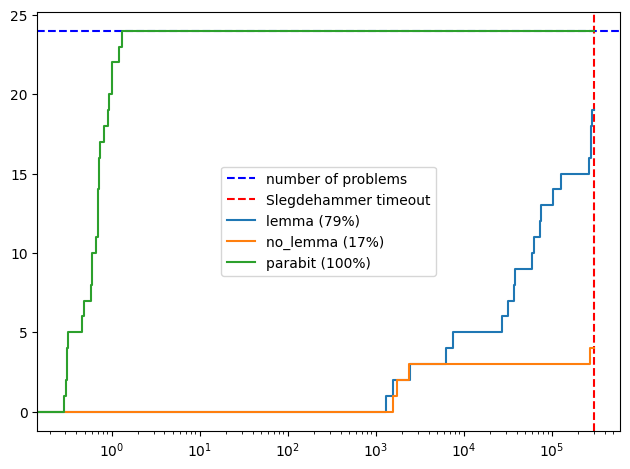

In [ ]:

data_comb = sledge['rover'].copy()
data_comb['parabit'] = egraph['rover']['runtime']

fig, ax = plt.subplots()

TIMEOUT = 5*60*1000

ax.axhline(len(data_comb), label='number of problems', linestyle='dashed', color='blue')
ax.axvline(TIMEOUT, label='Slegdehammer timeout', linestyle='dashed', color='red')

for name, values in data_comb.items():
    solved = values.dropna()
    x, y = prepare_step_data(solved.to_list())
    
    y.append(y[-1])
    x.append(TIMEOUT)
    
    ax.plot(x, y, "-", drawstyle="steps-post", label=f"{name} ({len(solved)/len(data_comb):.0%})")


ax.set_xscale('log')
ax.legend()
plt.tight_layout()
plt.show()


# Alive

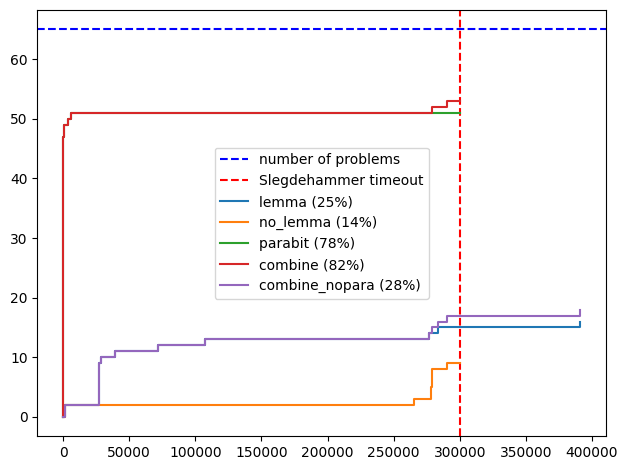

In [61]:
import math

data = sledge['alive'].copy()
data['parabit'] = egraph['alive']['runtime'].where(egraph['alive']['stop_reason'] == 'Equivalent')

data['combine'] = data.apply(lambda x: min(x.dropna().to_list()) if x.dropna().to_list() != [] else None, axis=1)
data['combine_nopara'] = data.apply(lambda x: min(x[['lemma', 'no_lemma']].dropna().to_list()) if x[['lemma', 'no_lemma']].dropna().to_list() != [] else None, axis=1)
# data['combine'] = data.apply(lambda x: print(x.dropna().to_list()), axis=1)


fig, ax = plt.subplots()

TIMEOUT = 5*60*1000

ax.axhline(len(data), label='number of problems', linestyle='dashed', color='blue')
ax.axvline(TIMEOUT, label='Slegdehammer timeout', linestyle='dashed', color='red')

for name, values in data.items():
    solved = values.dropna()
    x, y = prepare_step_data(solved.to_list())
    
    if x[-1] < TIMEOUT:
        y.append(y[-1])
        x.append(TIMEOUT)
    
    ax.plot(x, y, "-", drawstyle="steps-post", label=f"{name} ({len(solved)/len(data):.0%})")


# ax.set_xscale('log')
ax.legend()
plt.tight_layout()
plt.show()
